In [1]:
%matplotlib inline
import datetime
import json
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [2]:
db = global_connect()

## Load Agency 1 itineraries status

In [3]:
df_a1 = careful_query("""
SELECT DATE(created), distribution_center1 as agency, COUNT(1) as itineraries,
        SUM(CASE WHEN status = 'finished' THEN 1 ELSE 0	END) as finished,
        SUM(CASE WHEN status != 'finished' THEN 1 ELSE 0 END) as not_finished,
        SUM(CASE WHEN status = 'dropped' THEN 1 ELSE 0 END) as dropped,
        SUM(CASE WHEN status = 'cancelled' THEN 1 ELSE 0 END) as cancelled,
        SUM(CASE WHEN status = 'cancelledWithCharge' THEN 1 ELSE 0 END) as cancelled_wc
FROM ITINERARIES
WHERE distribution_center1=1
GROUP BY distribution_center1, DATE(created)
ORDER BY DATE(created)
""")
df_a1

,date,agency,itineraries,finished,not_finished,dropped,cancelled,cancelled_wc
0,2019-10-01,1,52,52,0,0,0,0
1,2019-10-02,1,67,67,0,0,0,0
2,2019-10-03,1,121,121,0,0,0,0
3,2019-10-04,1,43,43,0,0,0,0
4,2019-10-07,1,164,159,5,2,3,0
...,...,...,...,...,...,...,...,...
133,2020-03-06,1,169,159,10,1,8,0
134,2020-03-09,1,209,176,33,20,13,0
135,2020-03-10,1,142,135,7,0,6,0
136,2020-03-11,1,199,197,2,0,2,0


In [4]:
# set datetime index
df_a1['date'] = pd.to_datetime(df_a1['date'])
df_a1.set_index(df_a1['date'], inplace=True)
del df_a1['agency']

In [5]:
# calculate daily ratios
selection = ['finished', 'dropped', 'cancelled']
for col in selection:
    # we know min(itineraries) = 1, so we can do this with no worries
    df_a1[col + '_ratio'] = df_a1[col] / df_a1['itineraries']

ratios = [col + '_ratio' for col in selection]

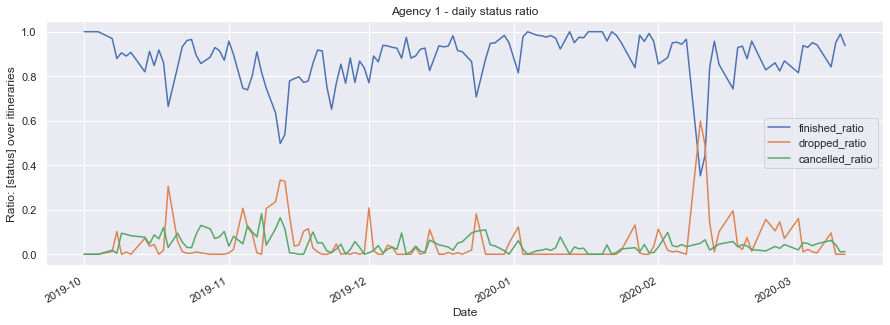

In [6]:
df_a1[df_a1.itineraries > 1][ratios].plot(figsize=(15,5));
plt.title('Agency 1 - daily status ratio');
plt.xlabel('Date')
plt.ylabel('Ratio: [status] over itineraries');

# Load Weather data

In [7]:
# The file was generated by the weather script.
filename = '../data/weather_daily_2019-10-01_2020-03-13.json'

if not os.path.exists(filename):
    raise 'file not exists'

with open(filename) as f:
    data = json.load(f)

In [8]:
# json into dataframe
df_w = pd.DataFrame(data).T

# will drop any column not listed here
selection = """
summary, icon, precipIntensity, precipProbability,
temperatureHigh, windGust, cloudCover
"""
selection = [col.strip() for col in selection.split(',')]
for col in df_w.columns:
    if col not in selection:
        del df_w[col]
    elif col not in ['summary', 'icon']:
        # set column type to float
        df_w[col] = df_w[col].astype('float')

In [9]:
df_w.index = pd.to_datetime(df_w.index)

In [10]:
# icon string into numeric value
i = {'clear-day': 0, 'partly-cloudy-day':0.33, 'cloudy': 0.67, 'rain': 1}
df_w['iconn'] = df_w['icon'].apply(lambda x: i[x])

In [11]:
df_w.columns

Index(['summary', 'icon', 'precipIntensity', 'precipProbability',
       'temperatureHigh', 'windGust', 'cloudCover', 'iconn'],
      dtype='object')

In [12]:
# agency 1 dates range
df_a1.index.min(), df_a1.index.max(), len(df_a1)

(Timestamp('2019-10-01 00:00:00'), Timestamp('2020-03-12 00:00:00'), 138)

In [13]:
# weather dates ranges
df_w.index.min(), df_w.index.max(), len(df_w)

(Timestamp('2019-10-01 00:00:00'), Timestamp('2020-03-12 00:00:00'), 164)

In [14]:
# timestamp into daily index (do not know if really required now)
df_a1.index = df_a1.index.to_period('D')
df_w.index = df_w.index.to_period('D')

In [15]:
# merge dataframe into a normalized one
dfn = pd.concat([df_a1, df_w], axis=1)
del dfn['date']
for col in dfn.columns:
    if col in ['icon', 'summary']: continue
    if 'ratio' in col: continue
    # normalize
    dfn[col + '_norm'] = (dfn[col]-dfn[col].min())/(dfn[col].max()-dfn[col].min())
    del dfn[col]

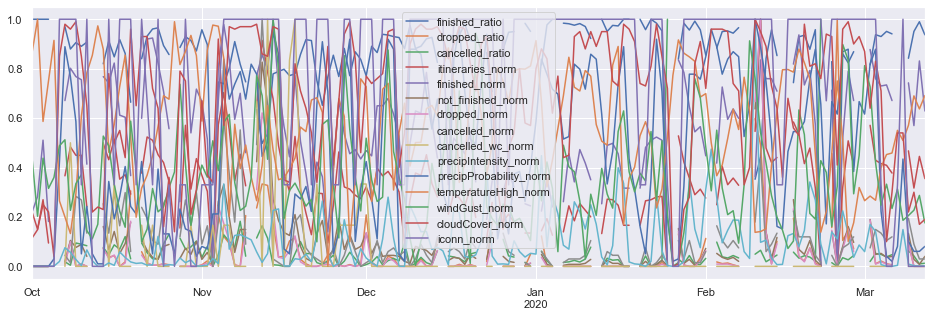

In [16]:
dfn.plot(figsize=(16,5));

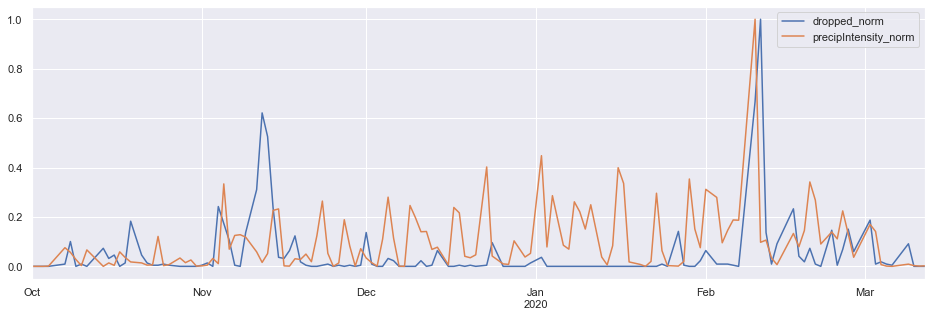

In [17]:
#selection = ['dropped_norm', 'dropped_ratio', 'precipIntensity_norm']
selection = ['dropped_norm', 'precipIntensity_norm']
dfn[selection].dropna().plot(figsize=(16,5));

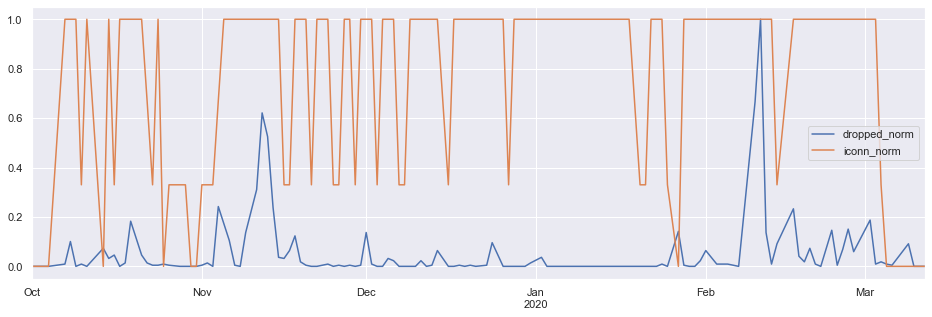

In [18]:
selection = ['dropped_norm', 'iconn_norm']
dfn[selection].dropna().plot(figsize=(16,5));

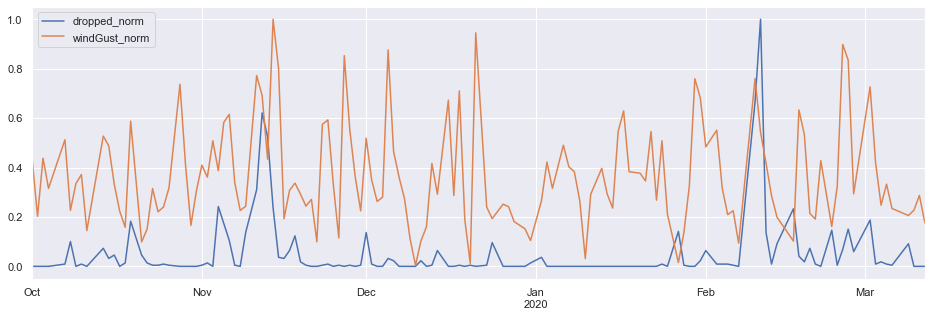

In [19]:
selection = ['dropped_norm', 'windGust_norm']
dfn[selection].dropna().plot(figsize=(16,5));

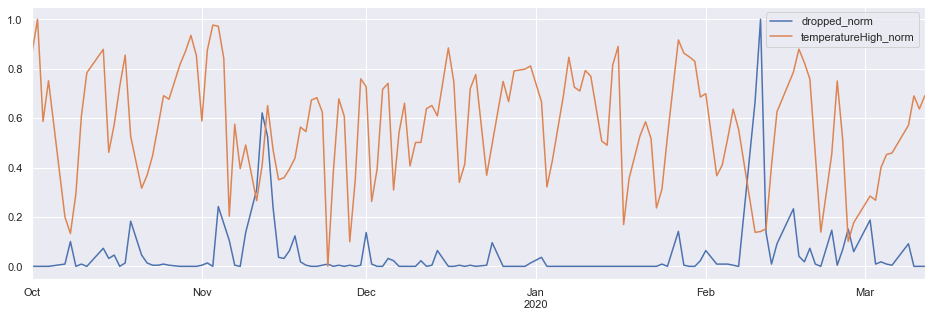

In [20]:
selection = ['dropped_norm', 'temperatureHigh_norm']
dfn[selection].dropna().plot(figsize=(16,5));

## Calculate correlations

In [21]:
# merge original agency and weather dataframes
df = pd.concat([df_a1, df_w], axis=1)

In [22]:
selection = ['itineraries'] + [col for col in df_w.columns if col not in ['icon','summary']]
df[selection].corr()['itineraries']

itineraries          1.000000
precipIntensity      0.024616
precipProbability    0.091826
temperatureHigh     -0.171884
windGust             0.161701
cloudCover           0.139317
iconn                0.049596
Name: itineraries, dtype: float64

Lower the temperature higher the number of itineraries. Weird.

In [23]:
selection = ['finished_ratio'] + [col for col in df_w.columns if col not in ['icon','summary']]
df[selection].corr()['finished_ratio']

finished_ratio       1.000000
precipIntensity     -0.092088
precipProbability   -0.055806
temperatureHigh      0.126875
windGust            -0.145255
cloudCover          -0.016131
iconn               -0.046631
Name: finished_ratio, dtype: float64

Lower the wind, greater the finished_ratio (motos are prone to work better with no wind)

In [24]:
selection = ['dropped_ratio'] + [col for col in df_w.columns if col not in ['icon','summary']]
df[selection].corr()['dropped_ratio']

dropped_ratio        1.000000
precipIntensity      0.239265
precipProbability    0.172170
temperatureHigh     -0.132999
windGust             0.200521
cloudCover           0.102021
iconn                0.178694
Name: dropped_ratio, dtype: float64

This shows that Ariel and I were not so wrong when we thought in using the **icon**!  
But the precipIntensity looks a better variable:  
**The more it rains the more nobody wants to accept the itineraries**
This means that we should add/test this variable (precipIntensity) into our model to predict dropped packages. There is a high correlation too with windGust.

In [25]:
selection = ['dropped'] + [col for col in df_w.columns if col not in ['icon','summary']]
df[selection].corr()['dropped']

dropped              1.000000
precipIntensity      0.229246
precipProbability    0.181936
temperatureHigh     -0.231237
windGust             0.276719
cloudCover           0.189296
iconn                0.155061
Name: dropped, dtype: float64

Number of dropped packages are correlated with: wind, temperature and rain!  
Our selected variable to test in our model are: **precipIntensity**, **windGust** and **temperatureHigh**

In [26]:
selection = ['cancelled_ratio'] + [col for col in df_w.columns if col not in ['icon','summary']]
df[selection].corr()['cancelled_ratio']

cancelled_ratio      1.000000
precipIntensity     -0.065776
precipProbability   -0.045159
temperatureHigh     -0.112097
windGust            -0.026795
cloudCover           0.023341
iconn               -0.039427
Name: cancelled_ratio, dtype: float64

**All of the correlations observed here strengthen the idea of using a linear model to predict number of dropped packages.**

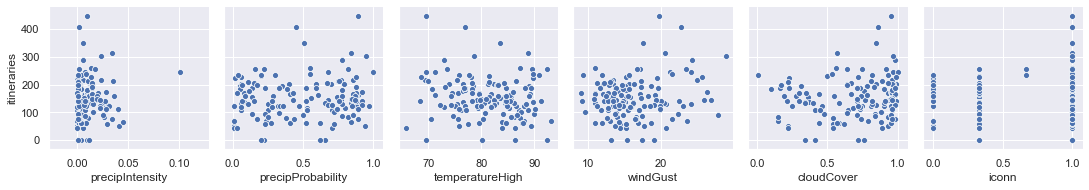

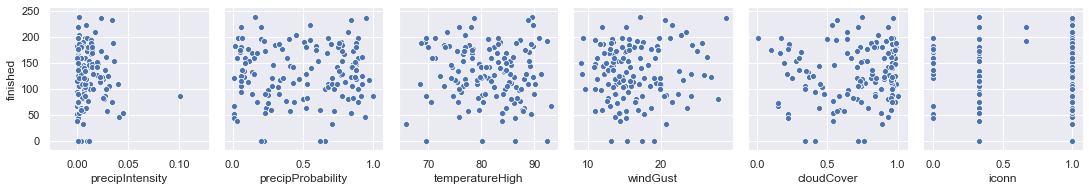

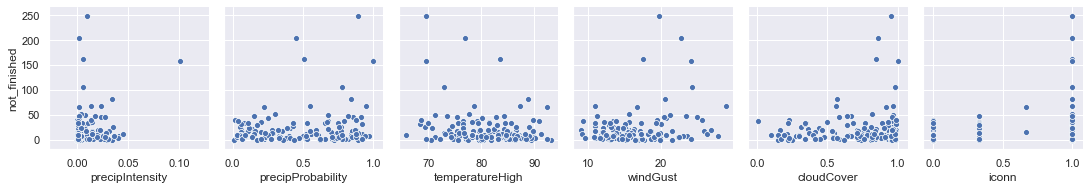

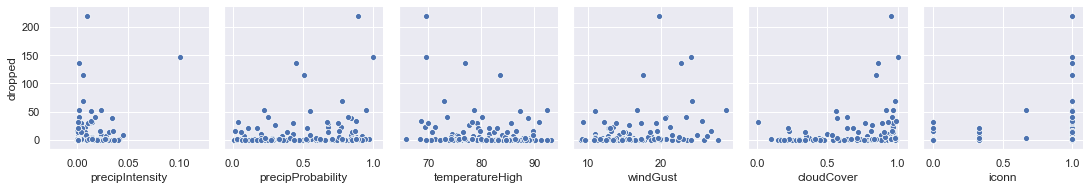

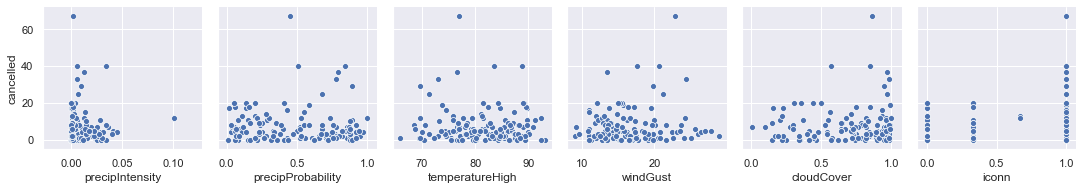

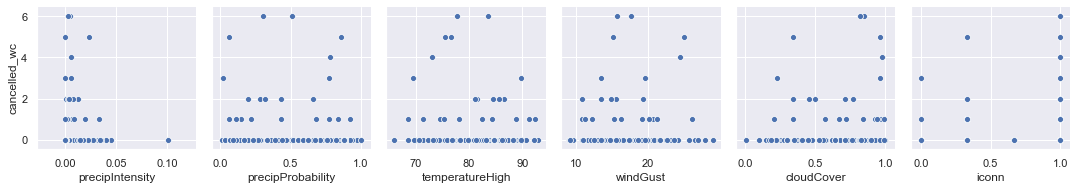

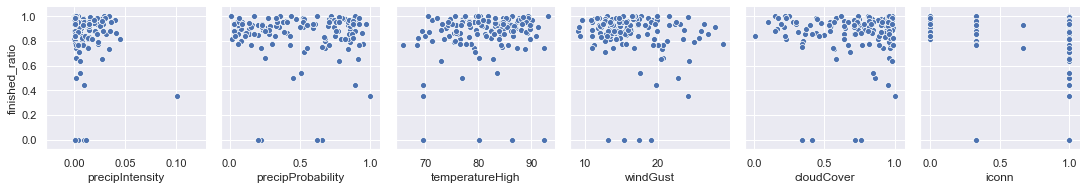

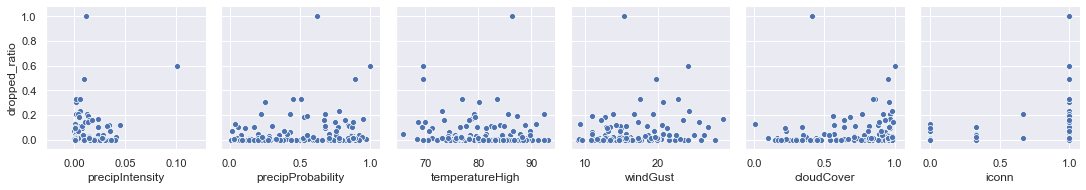

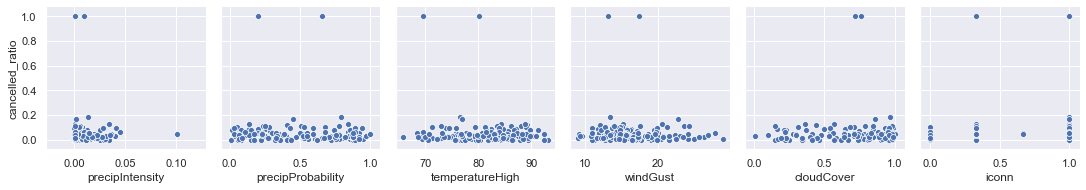

In [27]:
weather_cols = df_w.select_dtypes('number').columns.tolist()
for col in df_a1.select_dtypes('number').columns.tolist():
    sns.pairplot(x_vars=weather_cols, y_vars=col, data=df);
    plt.show()